# GPVAE model

In [1]:
import os
import sys

import numpy as np
import torch
import torch.nn as nn
import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy
from torch.utils.data import Dataset, DataLoader,random_split, Subset
from tqdm import tqdm

sys.path.append(os.path.abspath('..'))
from GP import *
from Models.GPVAE import GPVAE

import warnings
# Suppress only the specific GPInputWarning coming from the exact_gp.py file
warnings.filterwarnings(
    "ignore", 
    message="The input matches the stored training data. Did you forget to call model.train()?", 
    module=".*exact_gp"
)

In [2]:
# Import RICO data 
file_path = '../Data/RICO4_Dataset_processed.hdf'
df = pd.read_hdf(file_path)

df_h = df[df['temp_change_class'] == 'h']
def select_points(group):
    return group.iloc[::10]  # Select every 10th row
df_h = df_h.groupby('Scheduler Step').apply(select_points).reset_index(drop=True)
excluded_intervals = [53, 5]

df_h_filtered = df_h[~df_h['interval'].isin(excluded_intervals)].reset_index(drop=True)
df_h = df_h_filtered

class RICO4Dataset(Dataset):
    def __init__(self, df_h):
        self.df_h = df_h
        self.unique_intervals = df_h['interval'].unique()

    def __len__(self):
        return len(self.unique_intervals)

    def __getitem__(self, idx):
        batch = self.unique_intervals[idx]
        id = self.df_h['interval'] == batch
        temp = torch.tensor(self.df_h[id]['B.RTD1'].to_numpy(), dtype=torch.float32)
        ti = torch.tensor(self.df_h[id]['time_within_interval'].to_numpy()/240, dtype=torch.float32)
        x_batch = torch.cat((temp.unsqueeze(1), ti.unsqueeze(1)), axis=1)
        return x_batch
        
dataset = RICO4Dataset(df_h)
# Define split ratios
train_ratio = 0.7
test_ratio = 1-train_ratio

# Calculate split sizes
total_size = len(dataset)
train_size = int(train_ratio * total_size)
test_size = total_size - train_size

seed = 0
generator = torch.Generator().manual_seed(seed)

# Split the dataset
train_subset, test_subset = random_split(
    dataset,
    [train_size, test_size],
    generator=generator
)
train_loader = DataLoader(train_subset, batch_size=1, shuffle=False)
val_loader = DataLoader(test_subset, batch_size=1, shuffle=False)

/var/folders/46/30710m094qv2_dhfs08nzzd00000gn/T/ipykernel_6402/990737707.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_h = df_h.groupby('Scheduler Step').apply(select_points).reset_index(drop=True)


In [3]:
kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5))

torch.manual_seed(1)
model = GPVAE(GP_inf = GP_inference(kernel),
              activation_decoder=nn.ReLU(),
              hidden_layers_encoder=[10])

In [4]:
gp_params = []
base_params = []

for name, param in model.named_parameters():
    if 'GP' in name:
        gp_params.append(param)  # Gaussian Process parameters
    else:
        base_params.append(param)  # Other parameters

base_lr = 0.001  # Learning rate for base parameters
gp_lr = 0.0001  # Learning rate for GP parameters
# Create separate parameter groups in the optimizer
opt = torch.optim.Adam([
    {'params': base_params, 'lr': base_lr},
    {'params': gp_params, 'lr': gp_lr}
])
opt.zero_grad()


In [5]:
t_uni=torch.tensor(
    [  1.,  11.,  21.,  31.,  41.,  51.,  61.,  71.,  81.,  91., 101., 111.,
        121., 131., 141., 151., 161., 171., 181., 191., 201., 211., 221., 231.]
)

Training Progress:   5%|▍         | 16/350 [00:01<00:31, 10.60it/s]

Epoch 17:
  Training - Loss = 122.0599, KL = 0.4860, MSE = 122.5460, CE = 3.1907
  Validation - Loss = 105.8550, KL = 0.4853, MSE = 106.3404, CE = 3.1765
  Mean q_mu = 1.9743, Mean q_var = 31.9856


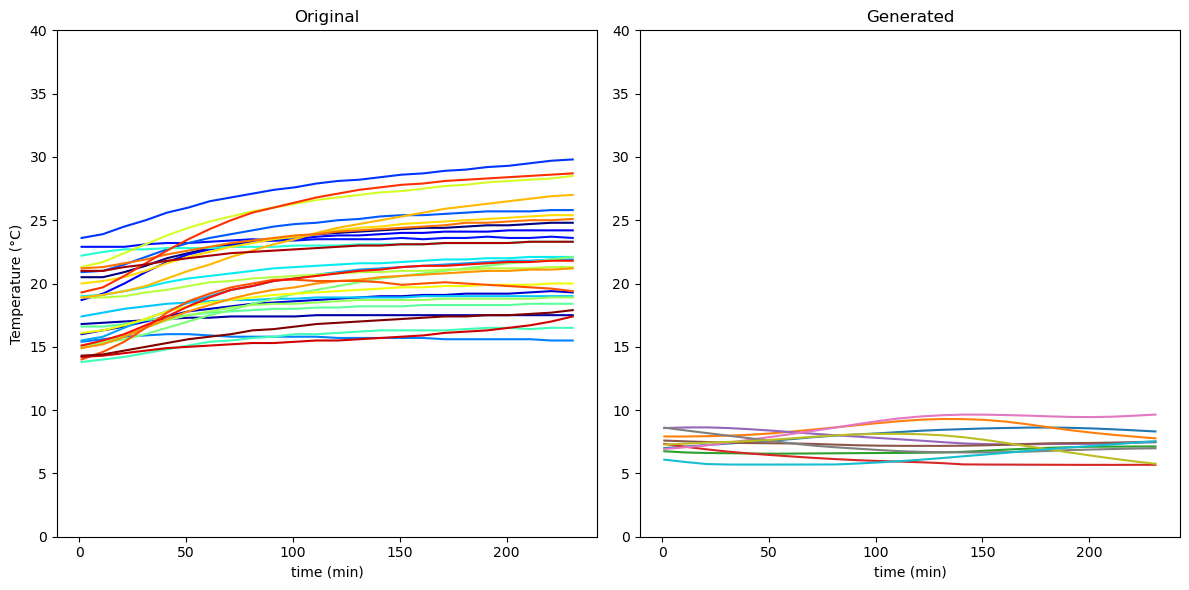

Training Progress:   9%|▉         | 32/350 [00:03<00:31, 10.00it/s]

Epoch 34:
  Training - Loss = 17.7582, KL = 0.4496, MSE = 18.2078, CE = 1.8951
  Validation - Loss = 12.4885, KL = 0.4496, MSE = 12.9381, CE = 1.8609
  Mean q_mu = 0.9404, Mean q_var = 2.4156


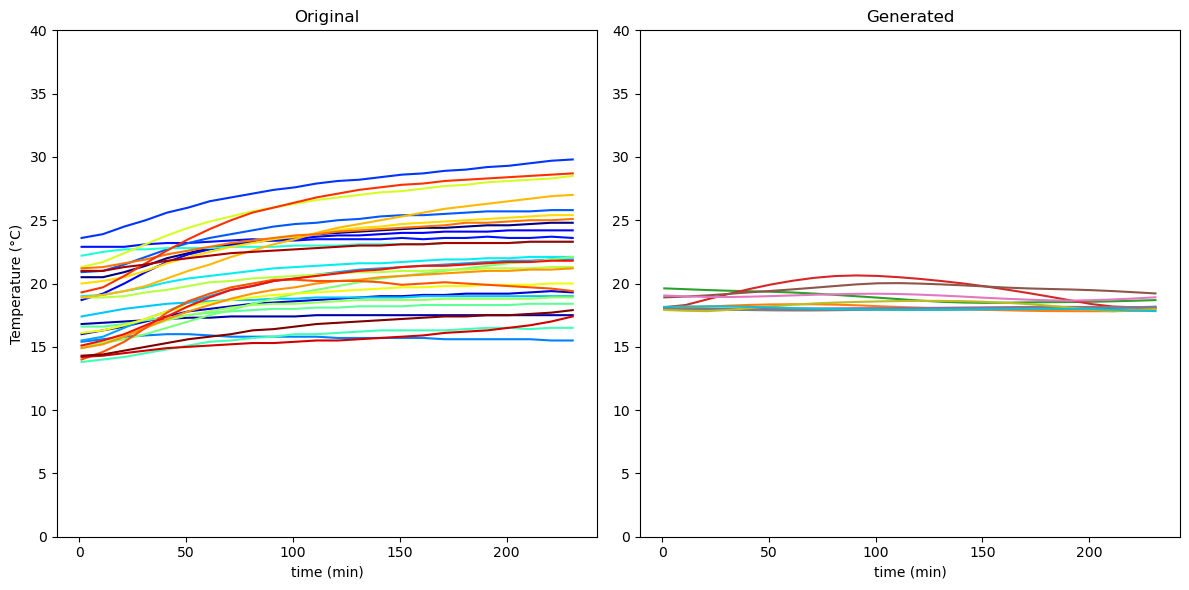

Training Progress:  14%|█▍        | 50/350 [00:05<00:28, 10.37it/s]

Epoch 51:
  Training - Loss = 13.7918, KL = 0.4255, MSE = 14.2174, CE = 1.3118
  Validation - Loss = 11.2478, KL = 0.4250, MSE = 11.6728, CE = 1.3109
  Mean q_mu = 0.6701, Mean q_var = 0.7355


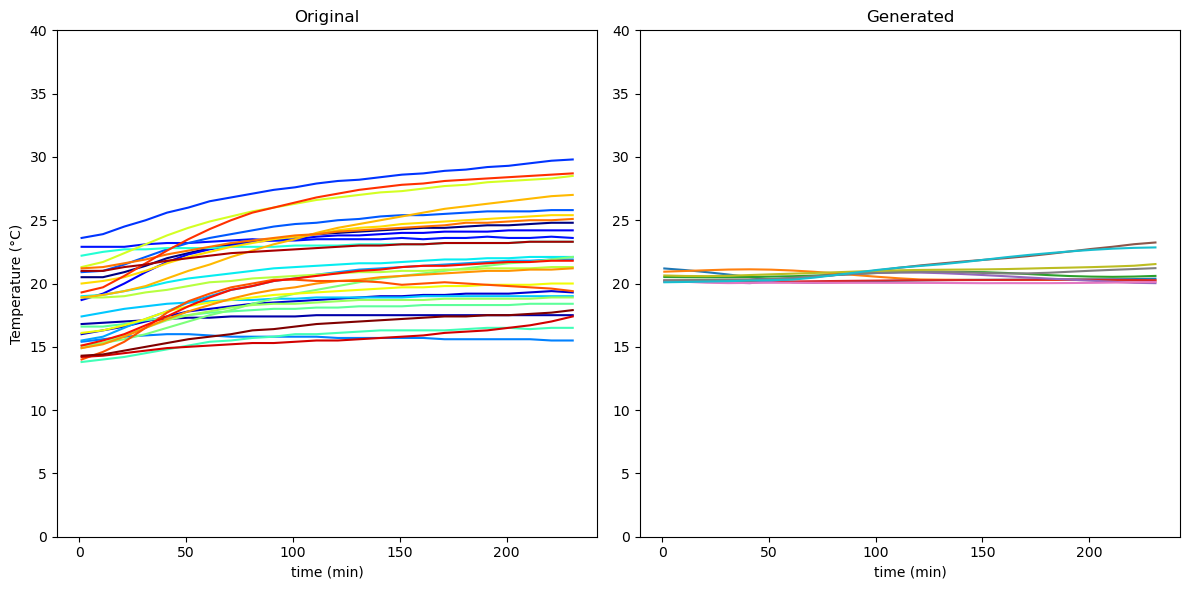

Training Progress:  19%|█▉        | 67/350 [00:07<00:26, 10.60it/s]

Epoch 68:
  Training - Loss = 12.9279, KL = 0.3902, MSE = 13.3181, CE = 1.2268
  Validation - Loss = 10.4942, KL = 0.3912, MSE = 10.8854, CE = 1.2171
  Mean q_mu = 1.1225, Mean q_var = 0.6145


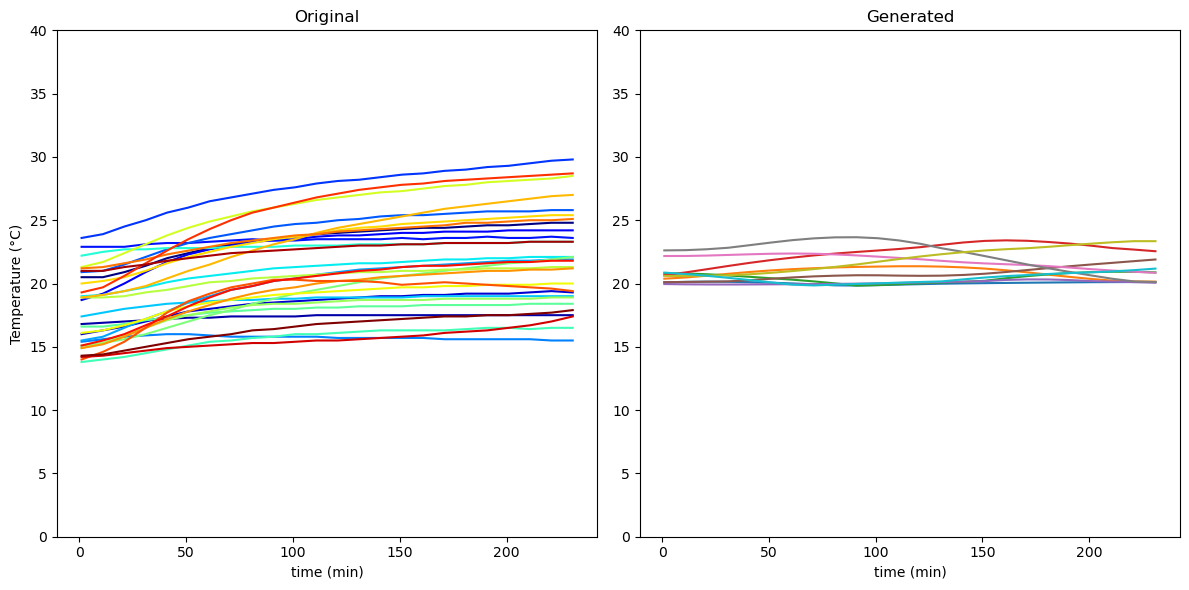

Training Progress:  24%|██▍       | 84/350 [00:08<00:24, 10.64it/s]

Epoch 85:
  Training - Loss = 11.0698, KL = 0.3401, MSE = 11.4100, CE = 1.0564
  Validation - Loss = 8.5526, KL = 0.3373, MSE = 8.8899, CE = 1.0537
  Mean q_mu = 1.4810, Mean q_var = 0.4325


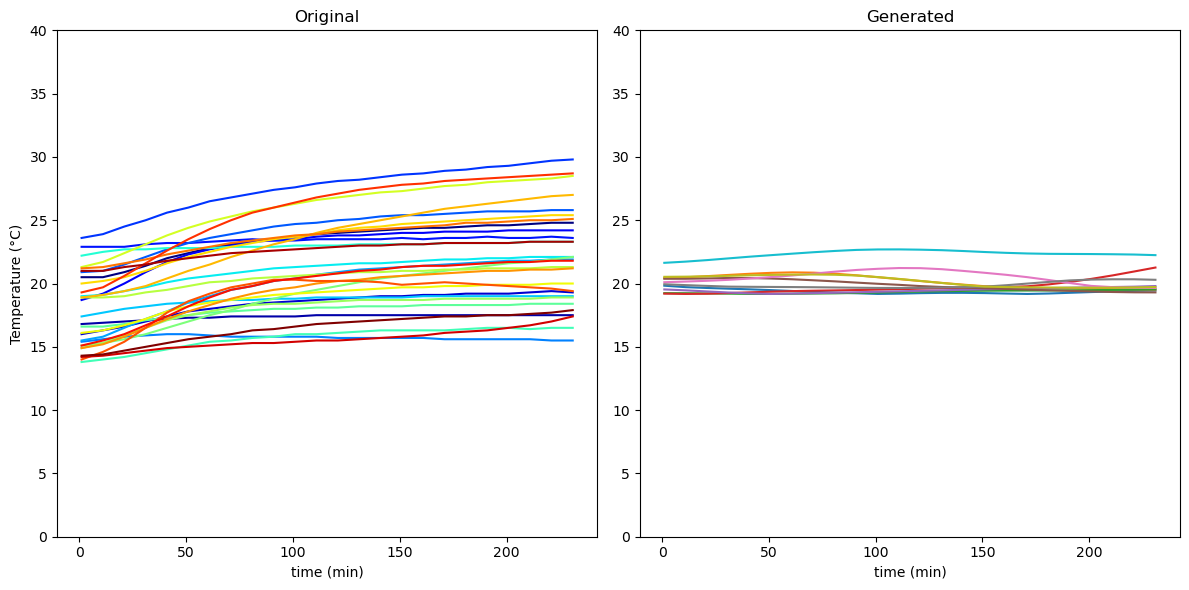

Training Progress:  29%|██▉       | 101/350 [00:10<00:23, 10.52it/s]

Epoch 102:
  Training - Loss = 8.4504, KL = 0.2927, MSE = 8.7431, CE = 0.8504
  Validation - Loss = 6.2369, KL = 0.2962, MSE = 6.5331, CE = 0.8449
  Mean q_mu = 1.6614, Mean q_var = 0.2828


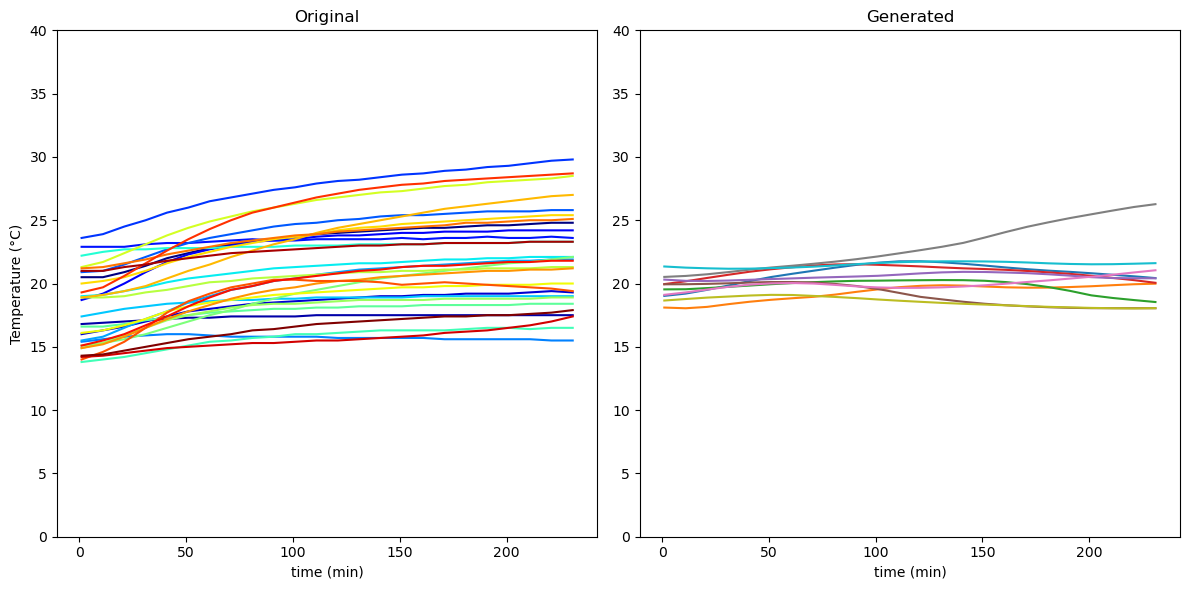

Training Progress:  34%|███▎      | 118/350 [00:12<00:22, 10.54it/s]

Epoch 119:
  Training - Loss = 4.7608, KL = 0.2580, MSE = 5.0188, CE = 0.6566
  Validation - Loss = 3.7799, KL = 0.2717, MSE = 4.0515, CE = 0.6422
  Mean q_mu = 1.6658, Mean q_var = 0.1888


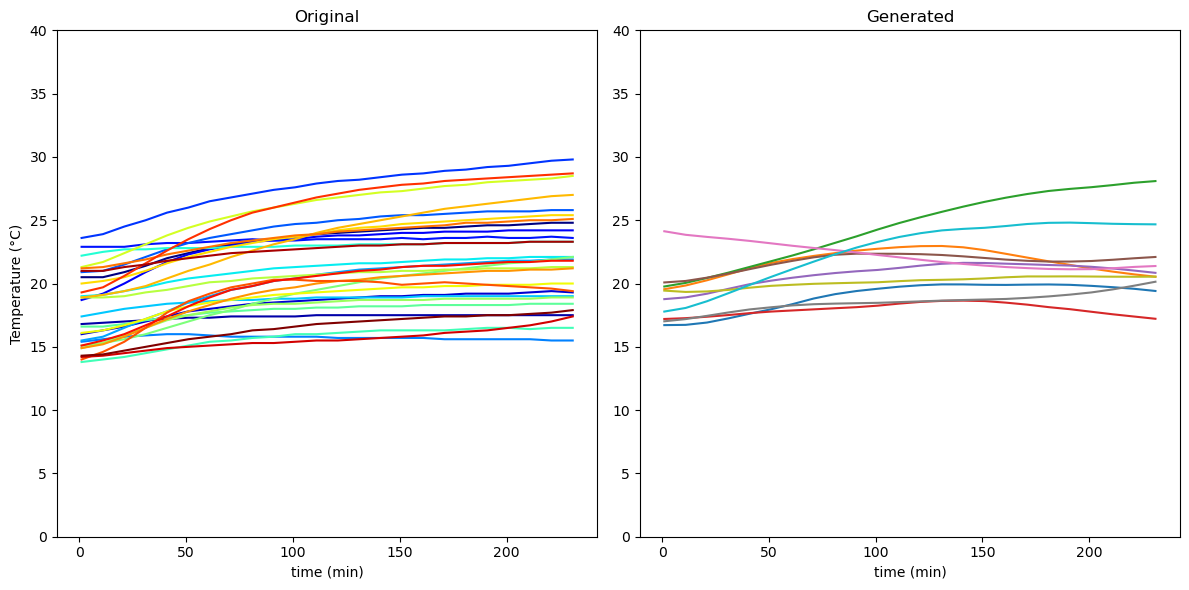

Training Progress:  39%|███▊      | 135/350 [00:13<00:20, 10.57it/s]

Epoch 136:
  Training - Loss = 2.2765, KL = 0.2238, MSE = 2.5003, CE = 0.4175
  Validation - Loss = 1.9258, KL = 0.2334, MSE = 2.1592, CE = 0.4047
  Mean q_mu = 1.5957, Mean q_var = 0.1148


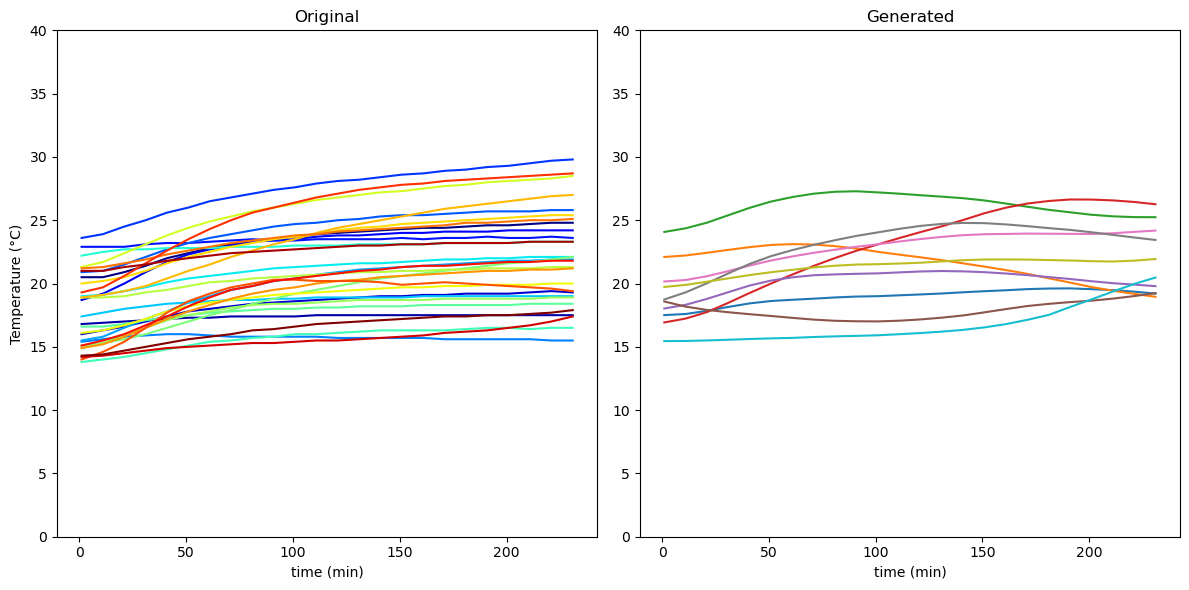

Training Progress:  43%|████▎     | 152/350 [00:15<00:18, 10.70it/s]

Epoch 153:
  Training - Loss = 1.2709, KL = 0.1898, MSE = 1.4607, CE = 0.1994
  Validation - Loss = 1.2065, KL = 0.2023, MSE = 1.4087, CE = 0.1878
  Mean q_mu = 1.5456, Mean q_var = 0.0730


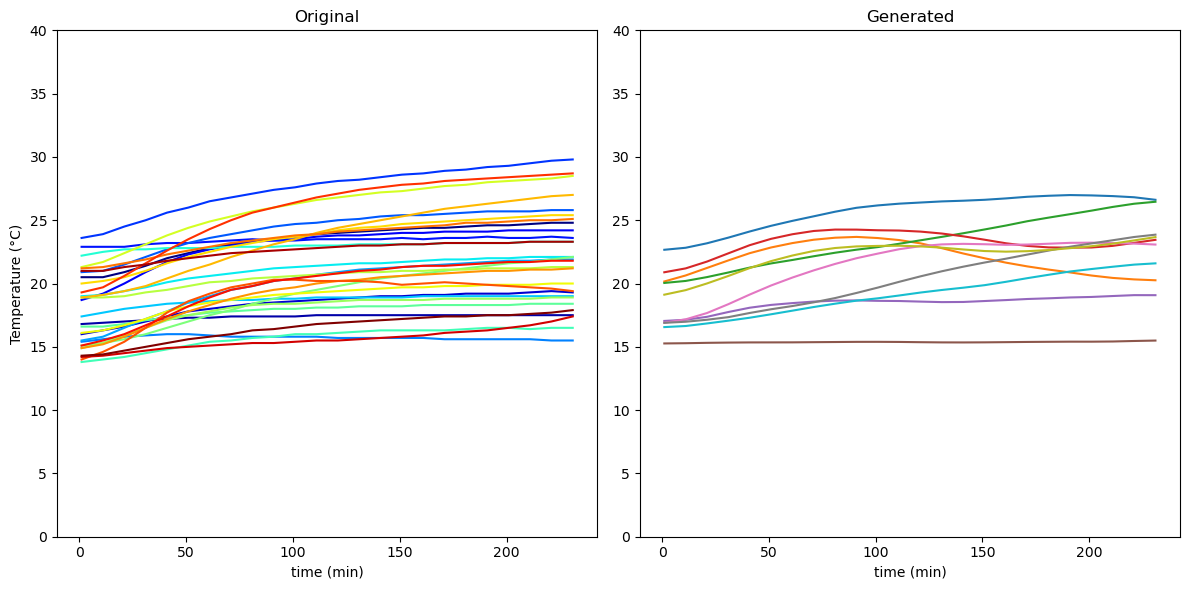

Training Progress:  48%|████▊     | 169/350 [00:17<00:21,  8.43it/s]

Epoch 170:
  Training - Loss = 0.7920, KL = 0.1671, MSE = 0.9591, CE = 0.0219
  Validation - Loss = 0.7105, KL = 0.1819, MSE = 0.8924, CE = 0.0157
  Mean q_mu = 1.4606, Mean q_var = 0.0506


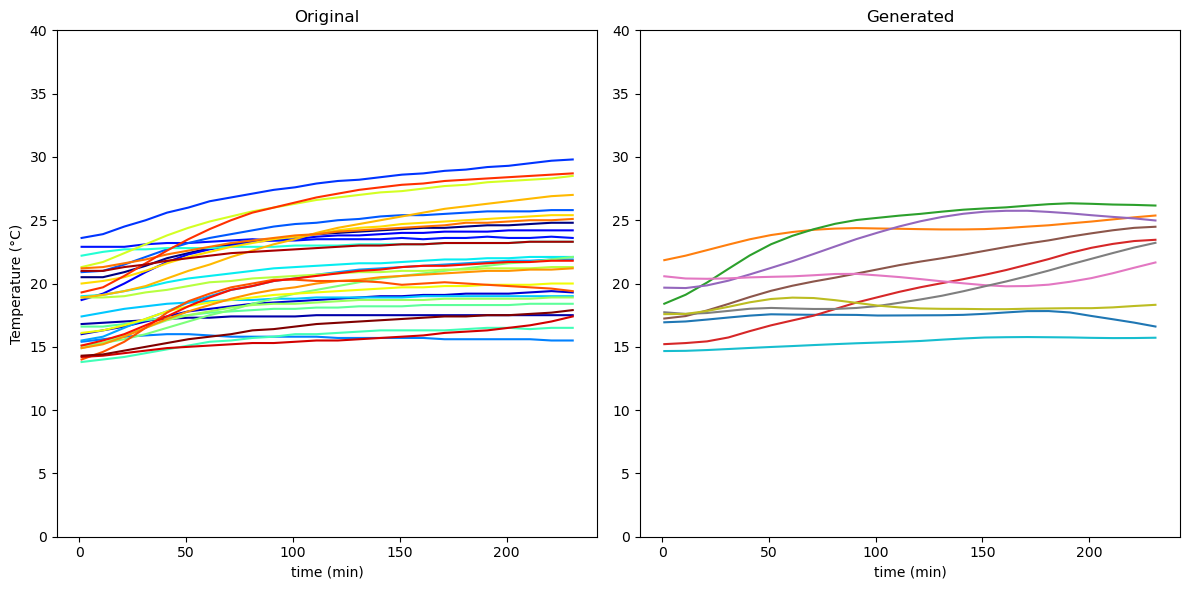

Training Progress:  53%|█████▎    | 186/350 [00:19<00:16,  9.65it/s]

Epoch 187:
  Training - Loss = 0.6285, KL = 0.1590, MSE = 0.7875, CE = 0.0200
  Validation - Loss = 0.6012, KL = 0.1745, MSE = 0.7757, CE = 0.0153
  Mean q_mu = 1.4484, Mean q_var = 0.0502


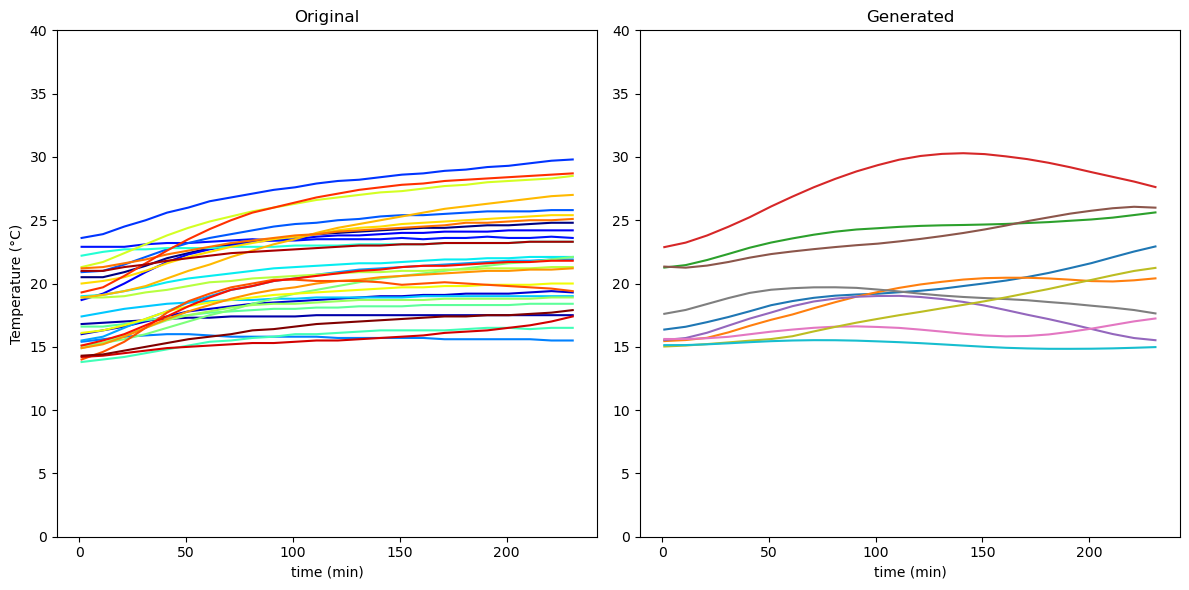

Training Progress:  58%|█████▊    | 202/350 [00:21<00:15,  9.59it/s]

Epoch 204:
  Training - Loss = 0.5794, KL = 0.1512, MSE = 0.7306, CE = 0.0217
  Validation - Loss = 0.5747, KL = 0.1751, MSE = 0.7498, CE = 0.0161
  Mean q_mu = 1.4572, Mean q_var = 0.0502


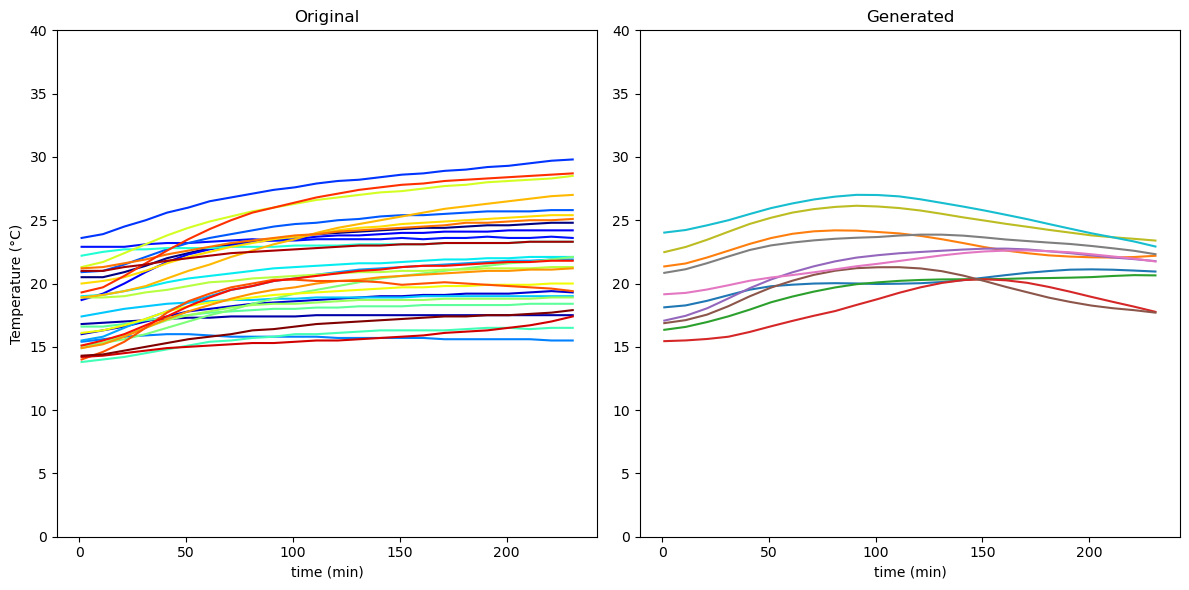

Training Progress:  63%|██████▎   | 220/350 [00:23<00:12, 10.54it/s]

Epoch 221:
  Training - Loss = 0.5587, KL = 0.1419, MSE = 0.7006, CE = 0.0218
  Validation - Loss = 0.4894, KL = 0.1594, MSE = 0.6488, CE = 0.0164
  Mean q_mu = 1.4878, Mean q_var = 0.0500


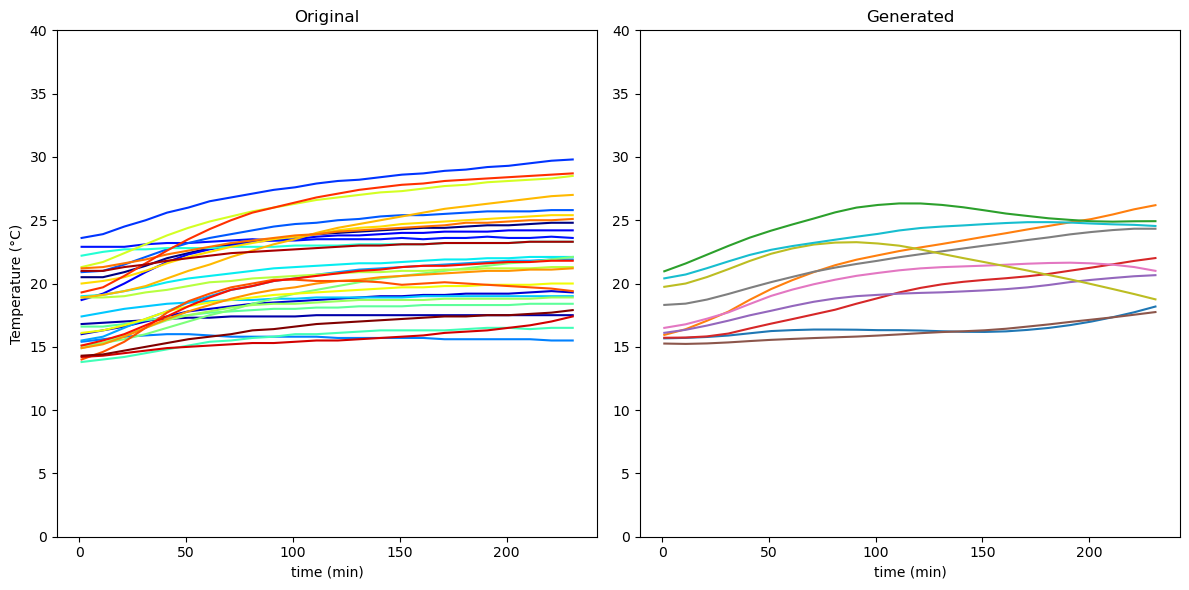

Training Progress:  68%|██████▊   | 237/350 [00:25<00:11, 10.22it/s]

Epoch 238:
  Training - Loss = 0.5493, KL = 0.1349, MSE = 0.6842, CE = 0.0232
  Validation - Loss = 0.4193, KL = 0.1616, MSE = 0.5809, CE = 0.0172
  Mean q_mu = 1.5011, Mean q_var = 0.0500


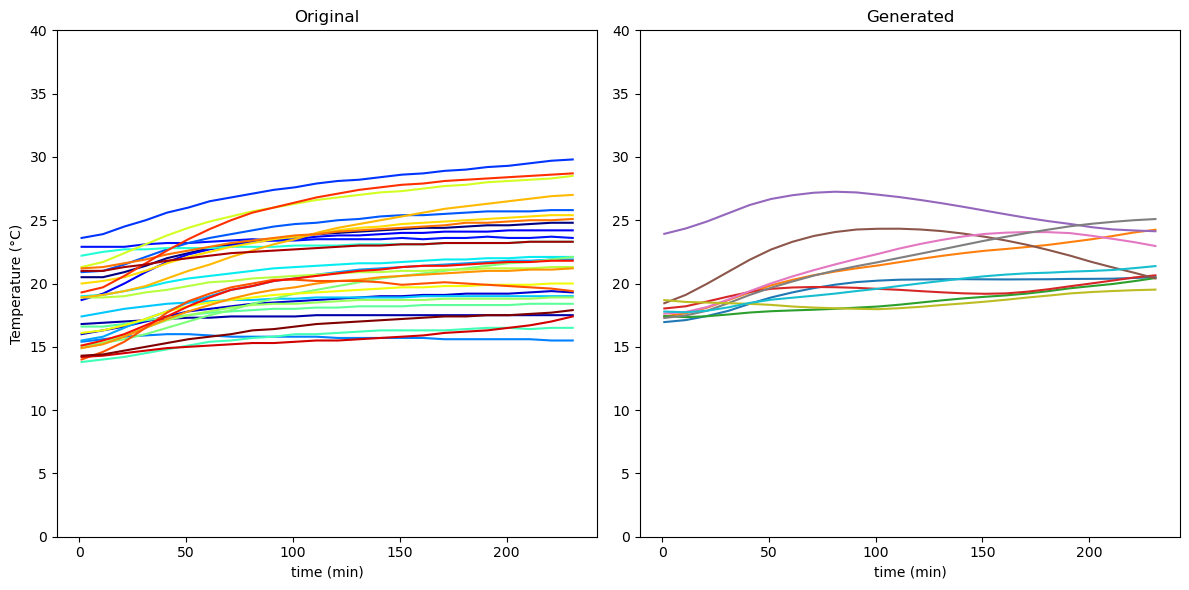

Training Progress:  73%|███████▎  | 254/350 [00:27<00:09,  9.96it/s]

Epoch 255:
  Training - Loss = 0.4970, KL = 0.1299, MSE = 0.6269, CE = 0.0242
  Validation - Loss = 0.6135, KL = 0.1620, MSE = 0.7755, CE = 0.0176
  Mean q_mu = 1.4895, Mean q_var = 0.0499


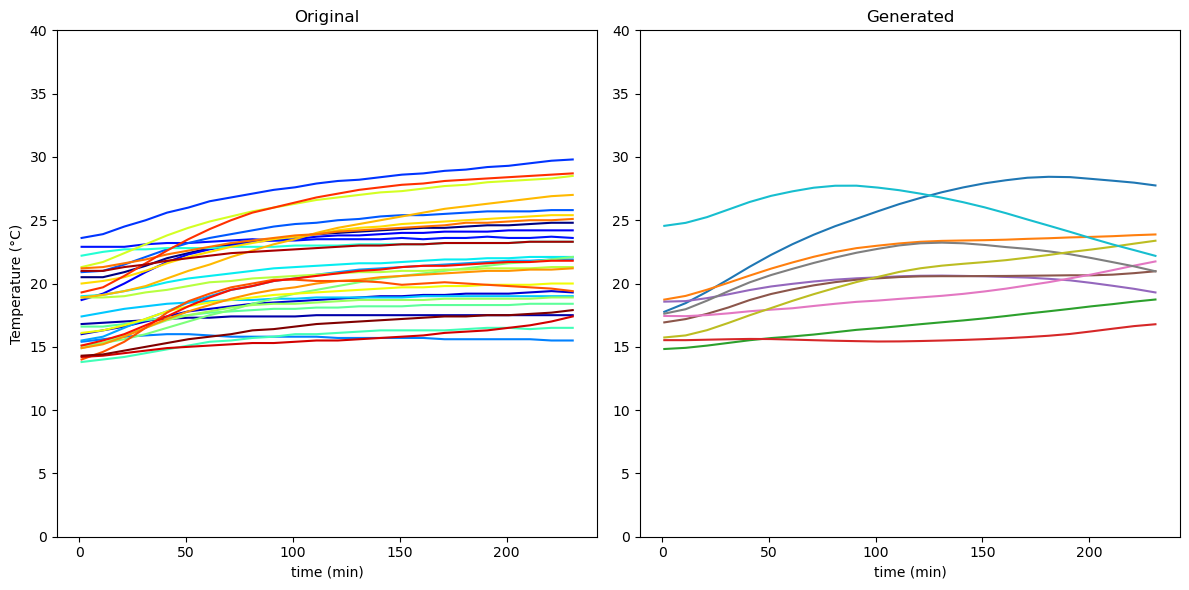

Training Progress:  77%|███████▋  | 271/350 [00:28<00:08,  9.51it/s]

Epoch 272:
  Training - Loss = 0.4451, KL = 0.1234, MSE = 0.5685, CE = 0.0258
  Validation - Loss = 0.4798, KL = 0.1559, MSE = 0.6357, CE = 0.0187
  Mean q_mu = 1.4972, Mean q_var = 0.0498


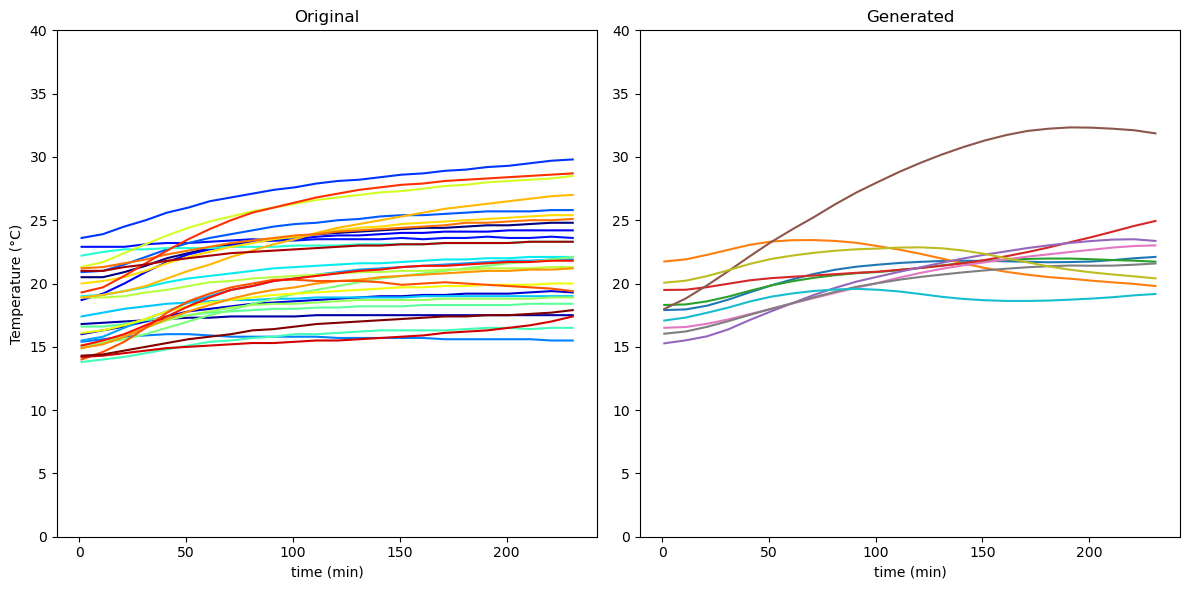

Training Progress:  82%|████████▏ | 287/350 [00:30<00:06, 10.25it/s]

Epoch 289:
  Training - Loss = 0.3907, KL = 0.1206, MSE = 0.5113, CE = 0.0272
  Validation - Loss = 0.4673, KL = 0.1535, MSE = 0.6208, CE = 0.0197
  Mean q_mu = 1.4657, Mean q_var = 0.0498


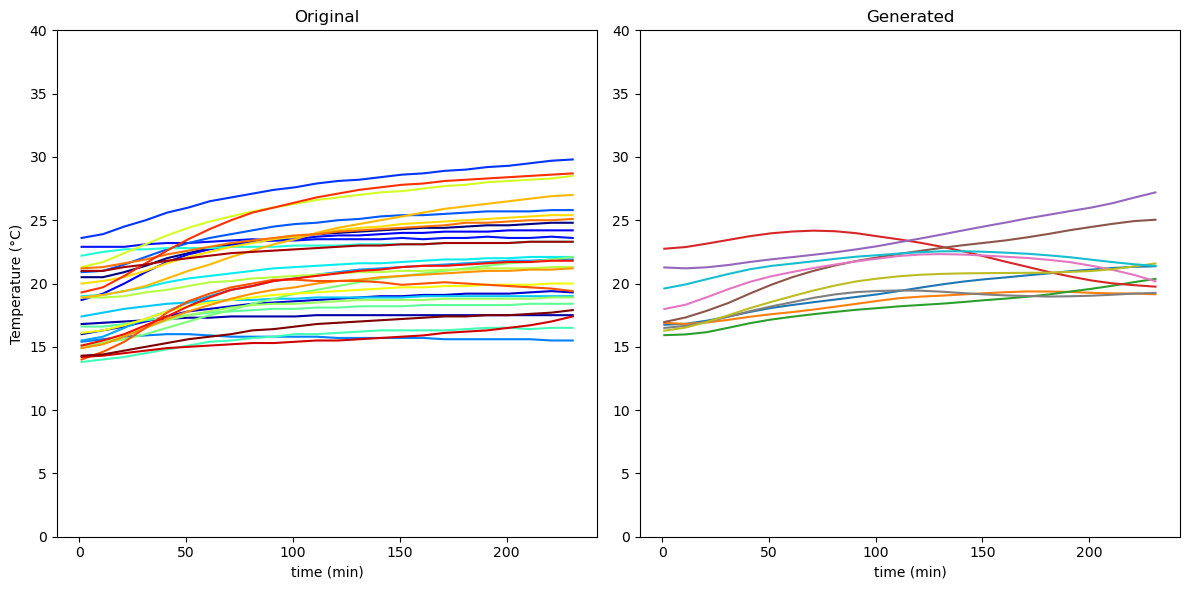

Training Progress:  87%|████████▋ | 305/350 [00:32<00:04, 10.24it/s]

Epoch 306:
  Training - Loss = 0.4800, KL = 0.1176, MSE = 0.5976, CE = 0.0288
  Validation - Loss = 0.3529, KL = 0.1561, MSE = 0.5091, CE = 0.0205
  Mean q_mu = 1.4309, Mean q_var = 0.0498


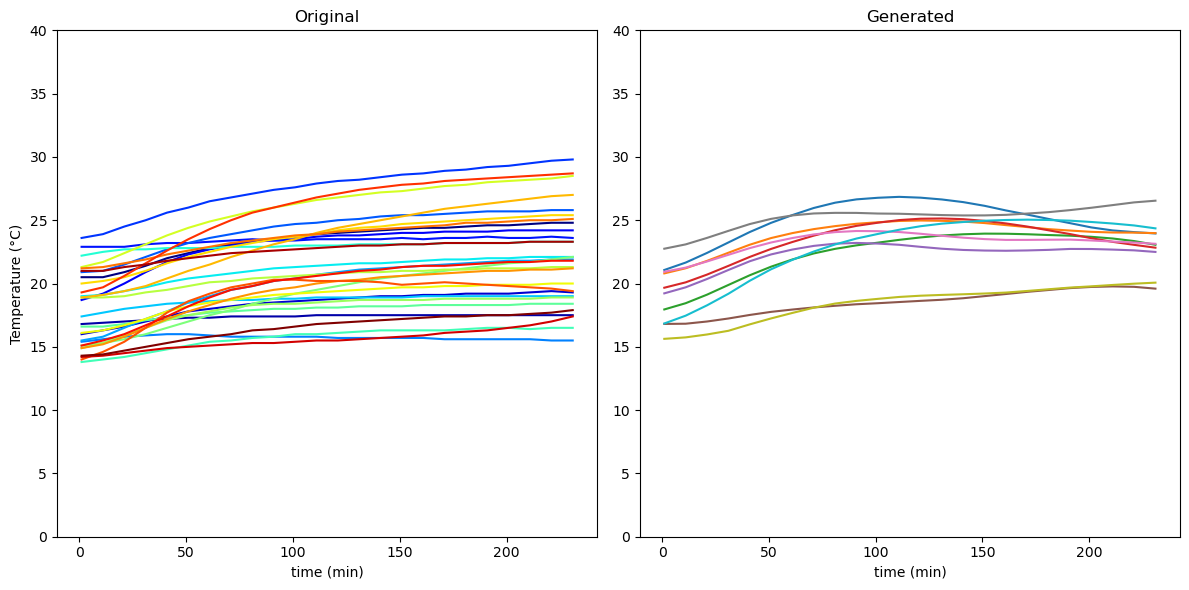

Training Progress:  92%|█████████▏| 322/350 [00:34<00:02, 10.32it/s]

Epoch 323:
  Training - Loss = 0.3526, KL = 0.1162, MSE = 0.4688, CE = 0.0299
  Validation - Loss = 0.3989, KL = 0.1543, MSE = 0.5532, CE = 0.0217
  Mean q_mu = 1.3701, Mean q_var = 0.0498


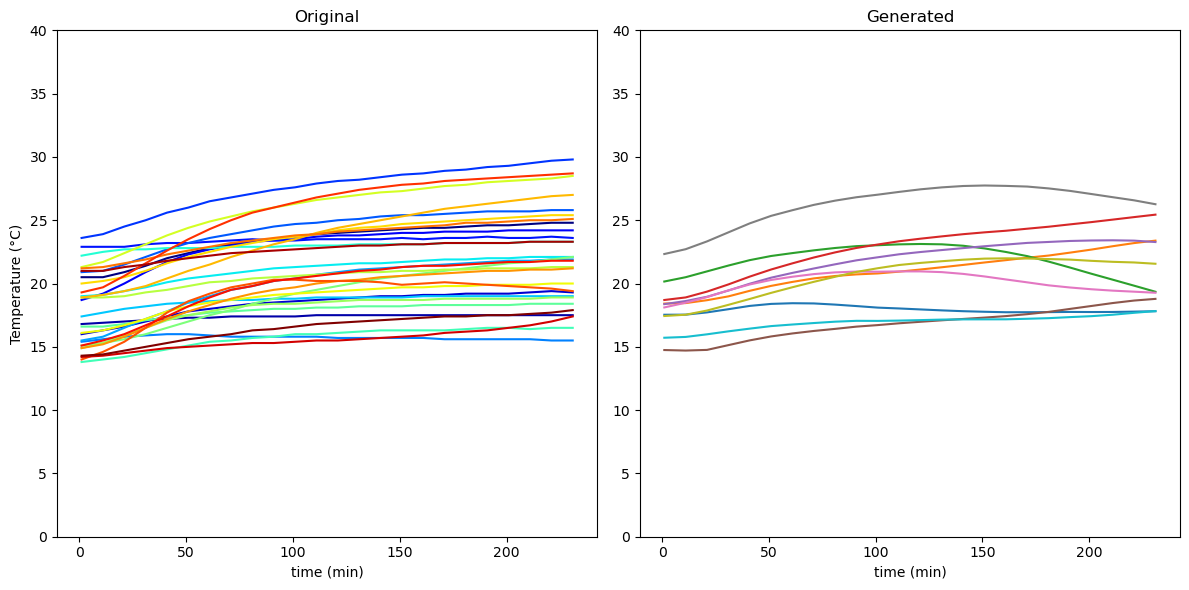

Training Progress:  97%|█████████▋| 338/350 [00:36<00:01, 10.05it/s]

Epoch 340:
  Training - Loss = 0.3694, KL = 0.1157, MSE = 0.4851, CE = 0.0318
  Validation - Loss = 0.2294, KL = 0.1516, MSE = 0.3811, CE = 0.0232
  Mean q_mu = 1.2952, Mean q_var = 0.0498


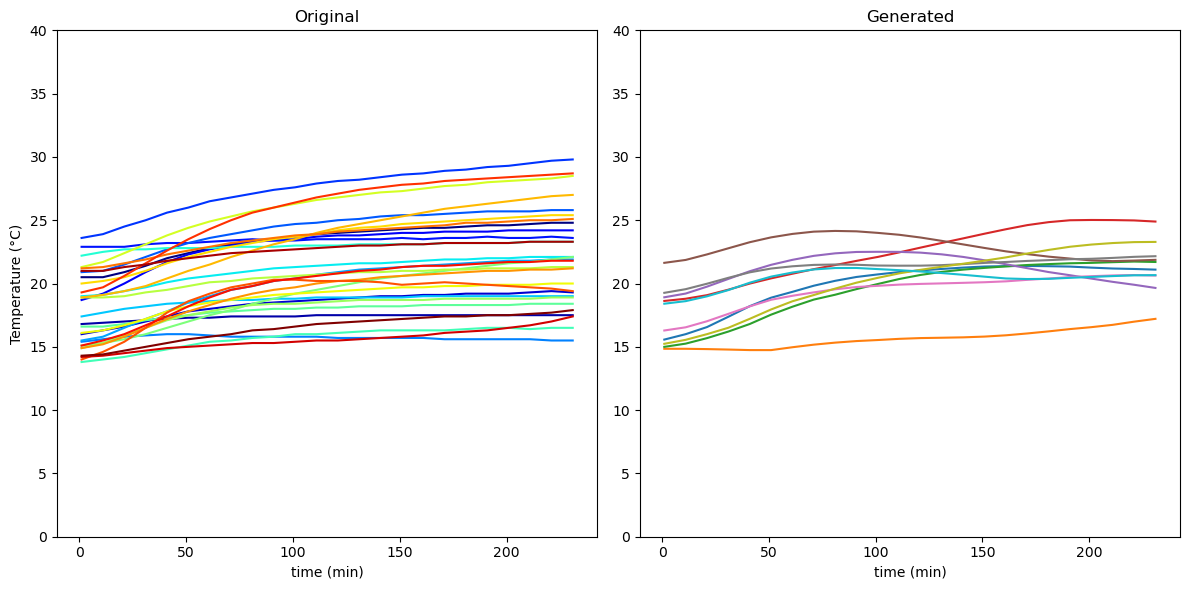

Training Progress:  99%|█████████▉| 348/350 [00:37<00:00,  9.95it/s]

Epoch 350:
  Training - Loss = 0.3989, KL = 0.1163, MSE = 0.5152, CE = 0.0325
  Validation - Loss = 0.2425, KL = 0.1484, MSE = 0.3909, CE = 0.0241
  Mean q_mu = 1.2539, Mean q_var = 0.0498


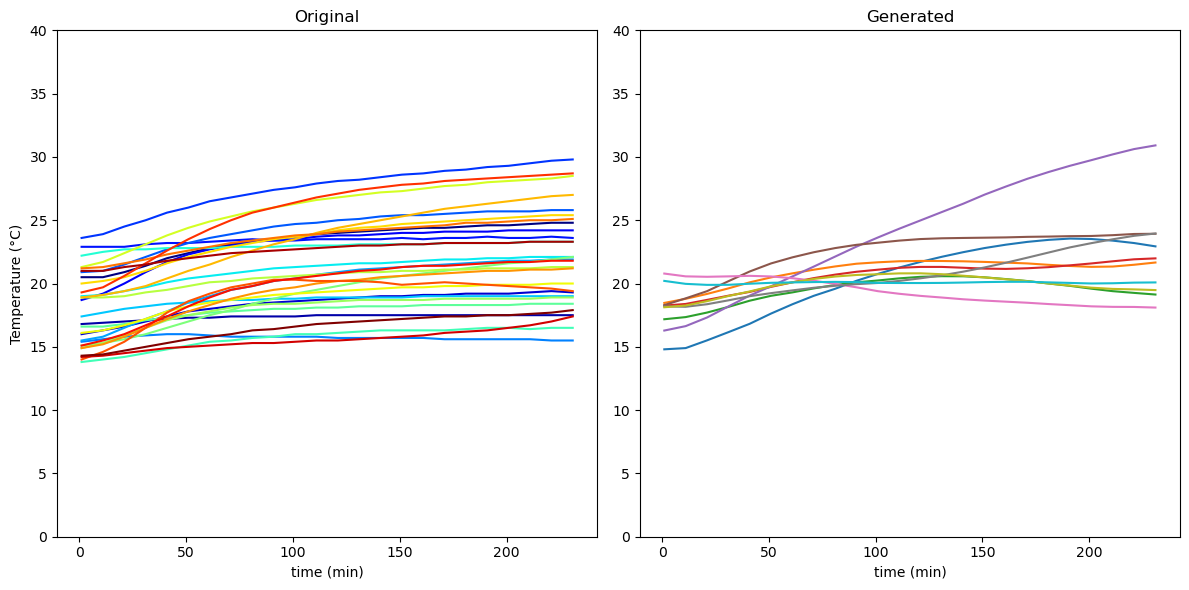

Training Progress: 100%|██████████| 350/350 [00:37<00:00,  9.36it/s]


In [6]:
beta = 1
num_epochs = 350
torch.manual_seed(123)
metrics = model.fit(train_loader, val_loader, 
                    opt, beta, num_epochs, 
                    t_uni=t_uni/240, 
                    num_samples=10, 
                    ylim=(0,40), 
                    df=df_h, 
                    plot=True)

In [7]:
torch.save(model.state_dict(), 'pre_trained_models/GPVAE_heating.pth')